<a href="https://colab.research.google.com/github/Lizette95/Team_RM5_ClassificationPredict_Notebook/blob/olouw_eda/Thoughts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is possible that the number of Pro tweets is related to the fact the "97 percent or more of actively publishing climate scientists agree: climate-warming trends over the past century are extremely likely due to human activities" ([Nasa](https://climate.nasa.gov/scientific-consensus/#*) ).

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#@title load dependencies
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
#import sys
#!{sys.executable} -m pip install wordcloud comet_ml scikit-learn

# Load Dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon') #Sentiment analysis
import spacy
nltk.download('punkt') #Punctuation

from collections import Counter
from wordcloud import WordCloud
from gensim.models import Phrases
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# @title Get Spacy Pretrained Model
# Large pretrained model
# Use medium if you have it
%%capture
# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en --force

# nlp=spacy.load('en')

print('Done')

# Load Data and Check duplicates

Loaded data contains atleast 1590 duplicated entries. 4 of them are found to have inconsistencies in their classes

In [7]:
# @title
df_train = pd.read_csv('Data/train.csv')

drop1 = df_train.drop_duplicates(['message', 'sentiment'])['tweetid'].values
drop2 = df_train.drop_duplicates(['message'])['tweetid'].values
print(f"Data is duplicated {len(df_train)-len(drop2)} times")

# Check for tweets that are the same but have different sentiments
ids = [tweet_id for tweet_id in drop1 if tweet_id not in drop2]
repeated_tweets = []
for tweet_id in ids:
  tweet = df_train[df_train['tweetid']==tweet_id]['message']
  repeated_tweets.append(tweet.values[0])

print('\n\n Tweets that are duplicate but have different sentiments:')
for repeated_tweet in repeated_tweets:
  print(df_train[df_train['message']==repeated_tweet])

# drop all duplicates from data set
df_train.drop_duplicates(['message', 'sentiment'], inplace=True)

# drop duplicates with inconsistent classes
inds_to_drop = []
for tweet_id in ids:
  inds_to_drop = df_train[df_train['tweetid']==tweet_id].index[0] 

df_train.drop(index=inds_to_drop, inplace = True)

df_train.set_index('tweetid', inplace=True)

Data is duplicated 1590 times


 Tweets that are duplicate but have different sentiments:
      sentiment                                            message  tweetid
258          -1  RT @Uniocracy: They'll tell you theyre doing i...   529327
5393          0  RT @Uniocracy: They'll tell you theyre doing i...   723133
       sentiment                                            message  tweetid
2390           2  RT @Channel4News: .@LeoDiCaprio calls on citiz...   460524
10351          1  RT @Channel4News: .@LeoDiCaprio calls on citiz...    93815
       sentiment                                            message  tweetid
8446           0  RT @realDonaldTrump: Where the hell is global ...   228082
12001         -1  RT @realDonaldTrump: Where the hell is global ...   663534
       sentiment                                            message  tweetid
9141           0  RT @COP22: In 4 days the most ambitious climat...   407156
14103          1  RT @COP22: In 4 days the most ambitious climat..

# Vader Sentiments compared with classes.
As part of problem statement it would be interesting to identify how each of the classes express themselves. This give insights into whether classes express themselves with cynicism, positivity or neither of the 2. 

It would be reasonable to assume that Pro-class tweets would express negative sentiments because global warming is not positive. Pro Tweeps believe in something negative and could express their belief with a level of synicism or negativity.

Shown below are the plots. The opinion expressed earlier is not fully supported by the data. Anti and Pro classes have similar (38.5% and 38.1%, respectively) proportion of tweets that express express themselves in a positive manner. The Anti class has a higher proportion of tweets that are negatively expressed than the pro group. It could possibly be because Anti climate proponents are associated with right wing politics , which is in turn associated populist hostiliy ([Matthew Lockwood, 2018](http://sro.sussex.ac.uk/id/eprint/81164/1/Right%20wing%20populism%20and%20the%20climate%20agenda%20Accepted%20Manuscript.pdf)).

It is noteworthy that Anti class has lowest proportion of tweets that are expressed with nuetrality as compared to the other classes' proportions. 

Neutrally expressed tweets are largest for the News class, as they are expected to deliver information in a balanced manner. Unexpectedly the proportion of tweets are expressed negatively. 

The tweets that fall under Nuetral class have a much larger proportion (49.2%) of tweets that are expressed positively. 

Assumption is wrong: The distributions appear to be very similar. Don't know how much of it is due to number of positive vs number negative sentiments.

Neutral and News tend be more nuetral as compared with proportions of other classes. Nuetral also tends to be more positive than the rest.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


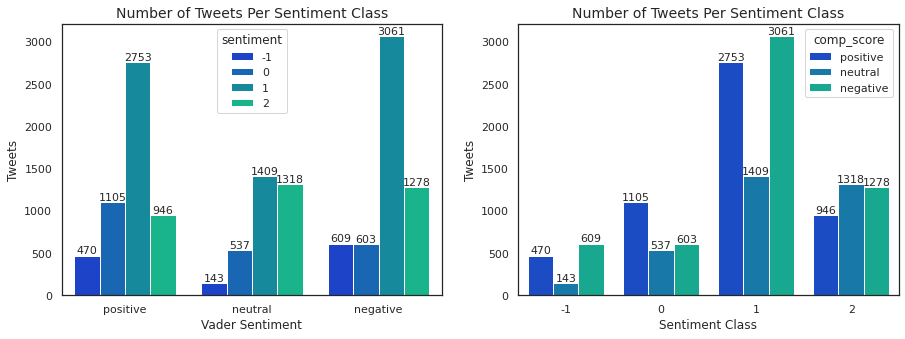

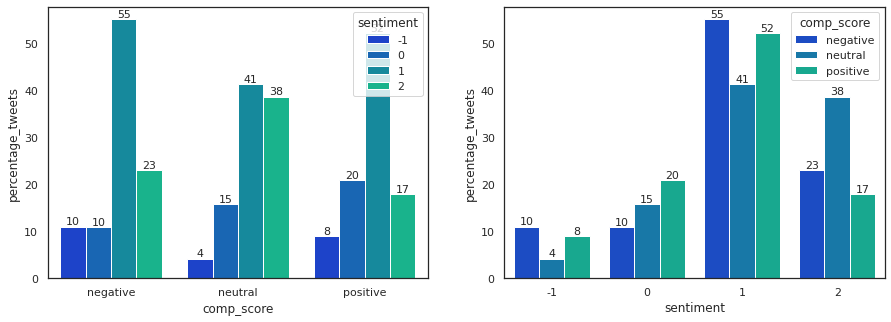

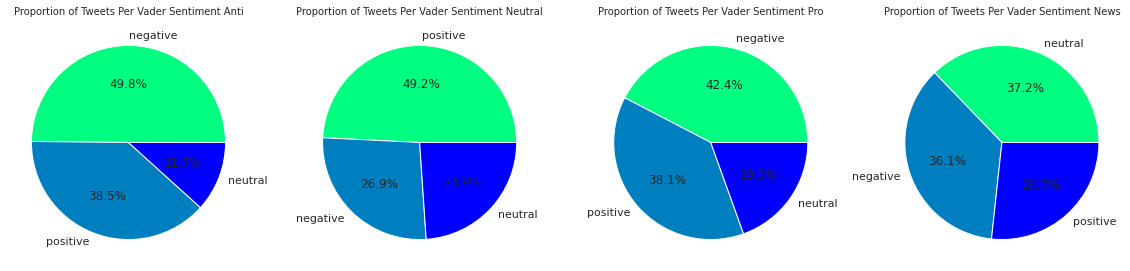

In [39]:
# @title Vader sentiment
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# df = df_train.copy()

#instantiate Sentiment analyzer
sid = SentimentIntensityAnalyzer()

# create function to determine if sentiment is positive, nuetral or negative
def sent_decider(compound):
  neutral_point = np.float128(0.00)
  if compound > neutral_point:
    return 'positive'#1
  elif compound < -neutral_point:
    return 'negative' #-1
  else: 
    return 'neutral'#0

#Get sentiment
df_train['scores'] = df_train['message'].apply(
                                      lambda review: sid.polarity_scores(review))
df_train['compound']  = df_train['scores'].apply(
                                      lambda score_dict: score_dict['compound'])
df_train['comp_score'] = df_train['compound'].apply(sent_decider)

#Plot code rom lizette
def put_numbers_on_bars(axis_object):
  for p in axis_object.patches:
    axis_object.text(p.get_x() + p.get_width()/2., p.get_height(), 
            '%d' % int(p.get_height()), fontsize=11, 
            ha='center', va='bottom')

fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='comp_score', 
                   data=df_train, 
                   palette='winter', 
                   hue='sentiment', 
                   ax=axis[0])
axis[0].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[0].set_xlabel('Vader Sentiment')
axis[0].set_ylabel('Tweets')
put_numbers_on_bars(ax)

ax = sns.countplot(x='sentiment', 
                   data=df_train, 
                   palette='winter', 
                   hue='comp_score', 
                   ax=axis[1])
axis[1].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[1].set_xlabel('Sentiment Class')
axis[1].set_ylabel('Tweets')
put_numbers_on_bars(ax)

plt.show()

#Plots as percentages
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))
counts = (df_train.groupby(['comp_score'])['sentiment']
                                                .value_counts(normalize=True)
                                                .rename('percentage_tweets')
                                                .mul(100)
                                                .reset_index())

ax = sns.barplot(x="comp_score", y="percentage_tweets", palette='winter',
                hue="sentiment", data=counts, ax=axis[0])
put_numbers_on_bars(ax)


count = (df_train.groupby(['sentiment'])['comp_score']
                                                .value_counts(normalize=True)
                                                .rename('percentage_tweets')
                                                .mul(100)
                                                .reset_index())

ax = sns.barplot(x="sentiment", y="percentage_tweets", palette='winter',
                hue="comp_score", data=counts, ax=axis[1])
put_numbers_on_bars(ax)


#Plot pie charts
fig, axis = plt.subplots(ncols=4, figsize=(20, 5))
group = ["Anti", "Neutral", "Pro", "News"]
for i in range(4):
  df_train[df_train['sentiment']==i-1]['comp_score'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[i])
  axis[i].set_title('Proportion of Tweets Per Vader Sentiment '+group[i],fontsize=10)
  axis[i].set_ylabel('')
plt.show()

# Retweets


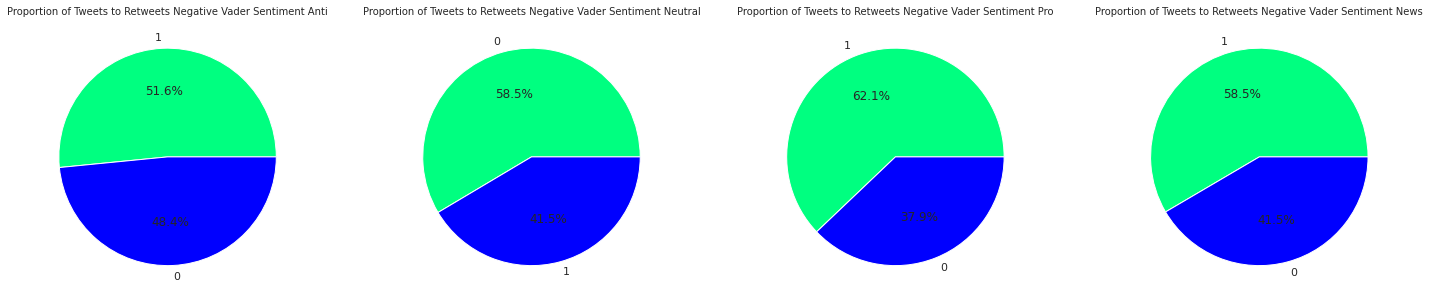

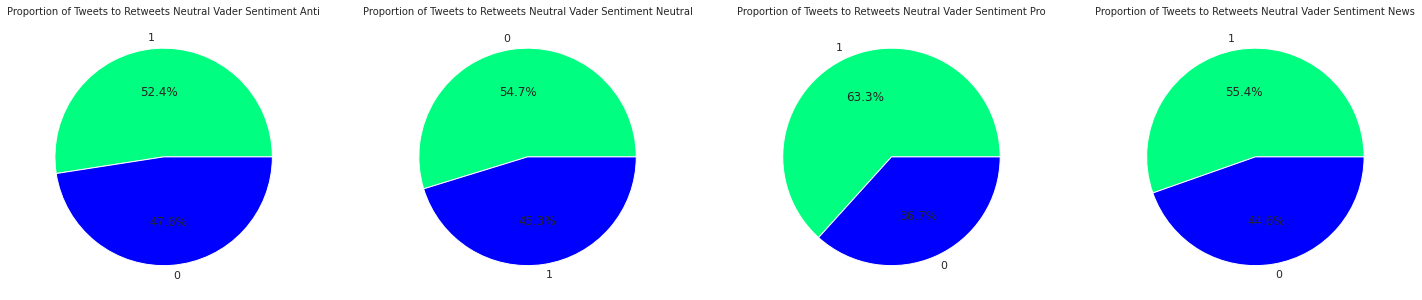

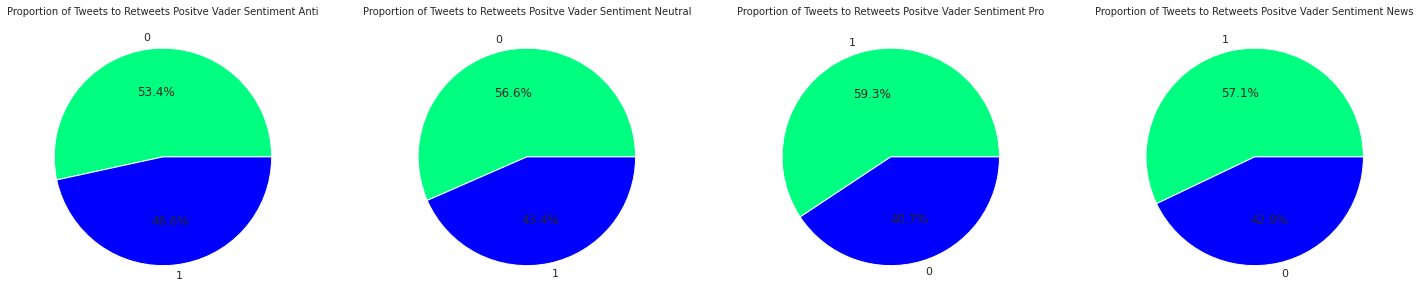

In [36]:
# @title Retweet Proportions
df_train['is_retweet'] = df_train['message'].apply(
                            lambda tweet: 1 if tweet.startswith('RT @') else 0)
fig, axis = plt.subplots(ncols=4, figsize=(25, 5))
group = ["Anti", "Neutral", "Pro", "News"]
for i in range(4):
  df_train[(df_train['sentiment']==i-1) & (df_train['comp_score']=='negative')]['is_retweet'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[i])
  axis[i].set_title('Proportion of Tweets to Retweets Negative Vader Sentiment '+group[i],fontsize=10)
  axis[i].set_ylabel('')
plt.show()

fig, axis = plt.subplots(ncols=4, figsize=(25, 5))
for i in range(4):
  df_train[(df_train['sentiment']==i-1) & (df_train['comp_score']=='neutral')]['is_retweet'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[i])
  axis[i].set_title('Proportion of Tweets to Retweets Neutral Vader Sentiment '+group[i],fontsize=10)
  axis[i].set_ylabel('')
plt.show()

fig, axis = plt.subplots(ncols=4, figsize=(25, 5))
for i in range(4):
  df_train[(df_train['sentiment']==i-1) & (df_train['comp_score']=='positive')]['is_retweet'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[i])
  axis[i].set_title('Proportion of Tweets to Retweets Positve Vader Sentiment '+group[i],fontsize=10)
  axis[i].set_ylabel('')
plt.show()
# sns.countplot(x='is_retweet', data=df_train, palette='winter', hue='sentiment')